In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

X = pd.concat([pd.read_parquet('data/wine/wine_review.parquet.gzip', columns=['variety', 'year', 'country', 'location']),pd.read_parquet('data/wine/mpnet_embeddings.parquet.gzip')], axis=1)
X.variety = X.variety.astype('category')
X.country = X.country.astype('category')
X.location = X.location.astype('category')
y = LabelEncoder().fit_transform(pd.read_parquet('data/wine/wine_review.parquet.gzip', columns=['points']).points)
print(X.shape, y.shape)
X.head()

(100538, 772) (100538,)


,variety,year,country,location,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,White Blend,2013,Italy,Etna,0.036825,0.040504,-0.049127,0.012060,-0.017809,0.045190,...,-0.018225,-0.022451,-0.030674,0.030395,-0.036411,0.075180,-0.021670,0.017032,-0.024503,-0.021728
1,Portuguese Red,2011,Portugal,Douro,0.015400,0.076190,-0.017931,0.004965,-0.076234,0.021419,...,-0.071278,0.033845,-0.002066,0.018129,-0.004691,0.028105,-0.042770,0.010317,0.063025,-0.026926
2,Pinot Gris,2013,US,Oregon,0.032447,0.012291,-0.034564,-0.020621,-0.048290,0.031377,...,-0.126703,0.035472,0.029064,0.006745,-0.012355,0.030802,-0.012589,0.024286,0.023172,-0.017200
3,Riesling,2013,US,Michigan,0.076041,0.044183,-0.017158,-0.041186,-0.030582,0.051051,...,-0.063876,-0.010313,0.004829,0.009389,-0.011263,0.035524,-0.014419,0.030267,-0.036529,-0.043187
4,Pinot Noir,2012,US,Oregon,0.011352,0.057223,-0.023293,0.022438,-0.078027,0.046609,...,-0.058865,0.031108,0.006709,0.020604,-0.017218,0.023554,-0.039825,0.021364,0.025454,-0.022300


In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

,variety,year,country,location,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
71166,Sangiovese,2004,Italy,Tuscany,-0.015517,-0.028565,-0.026781,0.053700,-0.004936,0.020011,...,-0.097514,-0.021607,0.013403,0.001048,-0.045254,0.019765,-0.018652,-0.001024,0.030262,0.033093
80735,Red Blend,2009,US,Washington,0.040970,-0.026239,-0.024915,-0.005610,-0.063496,-0.009150,...,-0.023481,0.030308,-0.017740,0.000611,0.005001,0.068376,-0.066297,0.019780,0.000633,-0.031555
25052,Sauvignon Blanc,2016,France,Côtes de Gascogne,0.068519,-0.005688,0.005931,0.014898,-0.036191,0.010095,...,-0.052174,-0.017084,0.017666,0.028166,-0.028412,0.006846,-0.051830,0.015403,0.043663,-0.062009
116451,Bordeaux-style Red Blend,2006,US,Colorado,0.045580,0.001349,-0.016296,0.006883,-0.051746,0.011897,...,-0.059892,0.024183,-0.005966,0.022143,-0.005425,0.006573,-0.025165,-0.003998,0.006135,-0.016485
14434,Pinot Noir,2013,US,California,0.013345,0.010441,-0.007903,0.004010,-0.054116,0.021753,...,-0.026164,-0.007857,-0.013207,0.018279,0.022725,0.030198,-0.043576,0.027668,-0.036869,0.010956


In [12]:
import shap
from xgboost import XGBClassifier

# train the XGBoost model
model = XGBClassifier(enable_categorical=True).fit(X_train, y_train)
model


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
# Use SHAP to explain the model
explainer = shap.TreeExplainer(model)
explainer

In [16]:
# Visualize the first instance of each class
shap_values = explainer.shap_values(X_test)
shap_values.shape

(20108, 772, 21)

In [20]:
X_test.shape


(20108, 772)

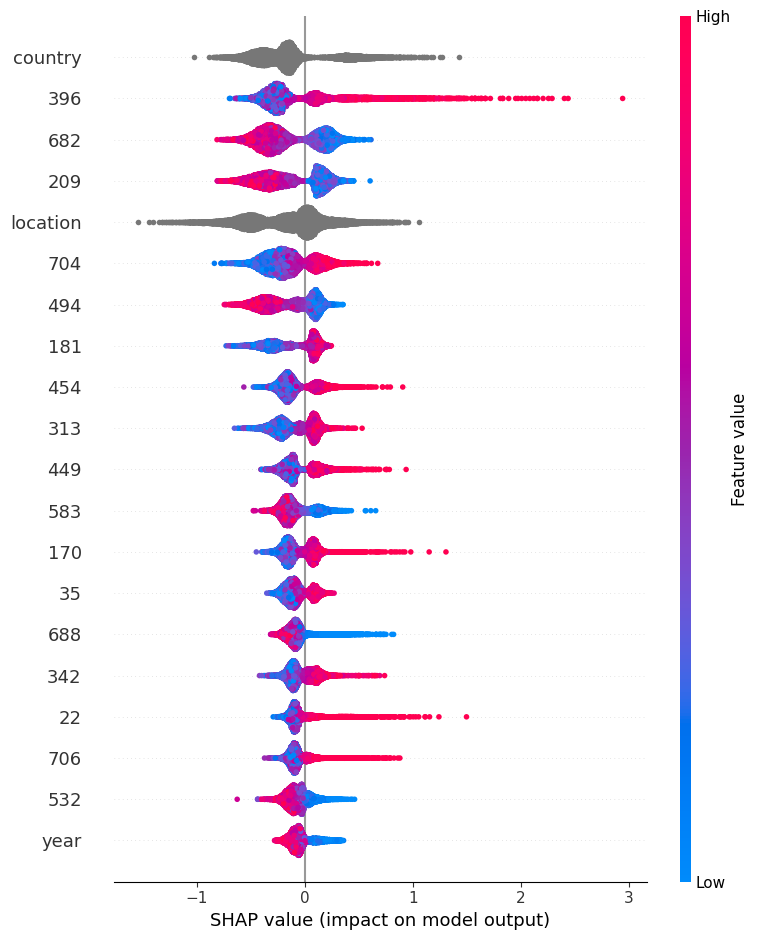

In [21]:
shap.summary_plot(shap_values[:,:,0], X_test)

In [1]:
import fasttext
import re
import lime.lime_text
import numpy as np
import webbrowser
from pathlib import Path

# This function regularizes a piece of text so it's in the same format
# that we used when training the FastText classifier.
def strip_formatting(string):
    string = string.lower()
    string = re.sub(r"([.!?,'/()])", r" \1 ", string)
    return string

# LIME needs to be able to mimic how the classifier splits
# the string into words. So we'll provide a function that
# mimics how FastText works.
def tokenize_string(string):
    return string.split()

# Load our trained FastText classifier model (created in Part 2)
classifier = fasttext.load_model('reviews_model_ngrams.bin')

# Create a LimeTextExplainer. This object knows how to explain a text-based
# prediction by dropping words randomly.
explainer = lime.lime_text.LimeTextExplainer(
    # We need to tell LIME how to split the string into words. We can do this
    # by giving it a function to call to split a string up the same way FastText does it.
    split_expression=tokenize_string,
    # Our FastText classifer uses bigrams (two-word pairs) to classify text. Setting
    # bow=False tells LIME to not assume that our classifier is based on single words only.
    bow=False,
    # To make the output pretty, tell LIME what to call each possible prediction from our model.
    class_names=["No Stars", "1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"]
)

# LIME is designed to work with classifiers that generate predictions
# in the same format as Scikit-Learn. It expects every prediction to have
# a probability value for every possible label.
# The default FastText python wrapper generates predictions in a different
# format where it only returns the top N highest likelihood results. This
# code just calls the FastText predict function and then massages it into
# the format that LIME expects (so that LIME will work).
def fasttext_prediction_in_sklearn_format(classifier, texts):
    res = []
    # Ask FastText for the top 10 most likely labels for each piece of text.
    # This ensures we always get a probability score for every possible label in our model.
    labels, probabilities = classifier.predict(texts, 10)

    # For each prediction, sort the probabaility scores into the same order
    # (I.e. no_stars, 1_star, 2_star, etc). This is needed because FastText
    # returns predicitons sorted by most likely instead of in a fixed order.
    for label, probs, text in zip(labels, probabilities, texts):
        order = np.argsort(np.array(label))
        res.append(probs[order])

    return np.array(res)

# Review to explain
review = "I didn't love this place :( The food wasn't very good and I didn't like the service either. Also, I found a bug in my food."

# Pre-process the text of the review so it matches the training format
preprocessed_review = strip_formatting(review)

# Make a prediction and explain it!
exp = explainer.explain_instance(
    # The review to explain
    preprocessed_review,
    # The wrapper function that returns FastText predictions in scikit-learn format
    classifier_fn=lambda x: fasttext_prediction_in_sklearn_format(classifier, x),
    # How many labels to explain. We just want to explain the single most likely label.
    top_labels=1,
    # How many words in our sentence to include in the explanation. You can try different values.
    num_features=20,
)

# Save the explanation to an HTML file so it's easy to view.
# You can also get it to other formats: as_list(), as_map(), etc.
# See https://lime-ml.readthedocs.io/en/latest/lime.html#lime.explanation.Explanation
output_filename = Path(__file__).parent / "explanation.html"
exp.save_to_file(output_filename)

# Open the explanation html in our web browser.
webbrowser.open(output_filename.as_uri())

ValueError: reviews_model_ngrams.bin cannot be opened for loading!